https://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf \\
https://www.justinsalamon.com/uploads/4/3/9/4/4394963/salamongomezmelodytaslp2012.pdf \\
http://web.archive.org/web/20120210104413/http://www.replaygain.org/


In [1]:
import numpy as np
from scipy import signal as sig
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt

In [42]:
sr, data = wav.read("/content/sample_data/ui.wav")

In [101]:
'''
yule_b = np.array([0.05418656406430, -0.02911007808948, -0.00848709379851, -0.00851165645469,
                   -0.00834990904936, 0.02245293253339, -0.02596338512915, 0.01624864962975,
                   -0.00240879051584, 0.00674613682247, -0.00187763777362])
yule_a = np.array([3.47845948550071, -6.36317777566148, 8.54751527471874, -9.47693607801280,
                   8.81498681370155, -6.85401540936998, 4.39470996079559, -2.19611684890774,
                   0.75104302451432, -0.13149317958808])
butter_b = np.array([0.98500175787242, -1.97000351574484, 0.98500175787242])
butter_a = np.array([1.96977855582618, -0.97022847566350])

num = np.convolve(yule_b, butter_b)
den = np.convolve(yule_a, butter_a)

eq_data = sig.lfilter(num, den, data)
'''

In [115]:
M = 2048
N = 8192
H = 128
win = sig.windows.hann(M, False)
SFT = sig.ShortTimeFFT(win, hop=H, fs=sr, mfft=N, scale_to='magnitude')
Sx = SFT.stft(data)

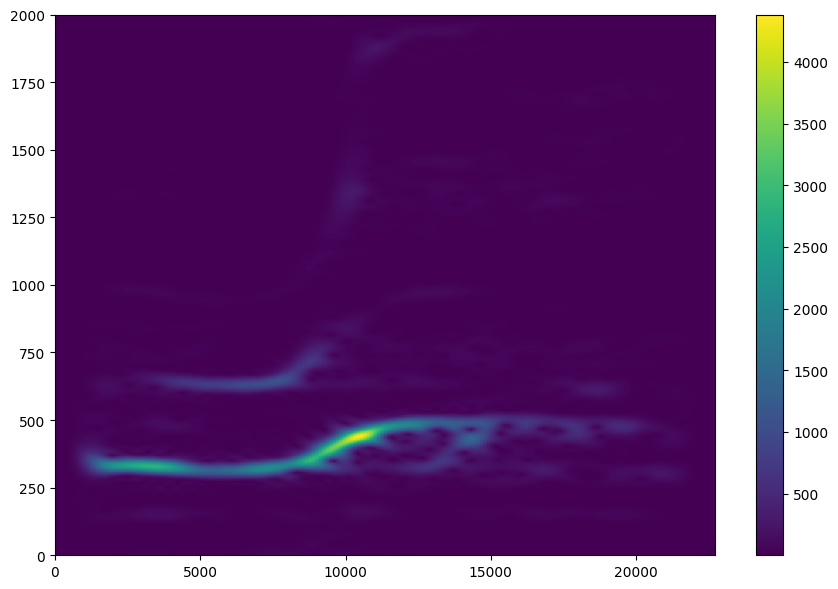

In [116]:
fig1, ax1 = plt.subplots(figsize=(9., 6.))
ax1.set(ylim=(0, 2000))

im1 = ax1.imshow(abs(Sx), origin='lower', aspect='auto',
                 extent=SFT.extent(sr*np.size(data)), cmap='viridis')
fig1.colorbar(im1)
fig1.tight_layout()

plt.show()

In [120]:
peaks = sig.argrelmax(abs(Sx), axis=1, order=2)

peak_ids = np.zeros(0, dtype=int)
for i in range(peaks[0].size):
  if abs(Sx[peaks[0][i], peaks[1][i]]) > 150:
    peak_ids = np.append(peak_ids, i)

peaks_f = peaks[0][peak_ids]
peaks_t = peaks[1][peak_ids]

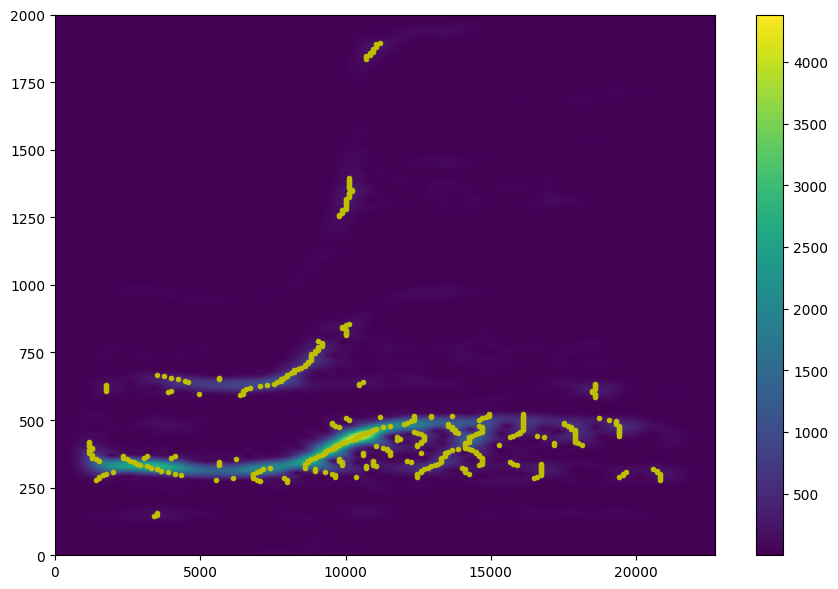

In [121]:
fig1, ax1 = plt.subplots(figsize=(9., 6.))
ax1.set(ylim=(0, 2000))

extents = SFT.extent(sr*data.size)
x_scale = data.size/Sx.shape[1]
y_scale = sr/N

im1 = ax1.imshow(abs(Sx), origin='lower', aspect='auto',
                 extent=extents, cmap='viridis')
ax1.plot(peaks_t * x_scale, peaks_f * y_scale, 'y.')

fig1.colorbar(im1)
fig1.tight_layout()

plt.show()

In [122]:
IF = np.zeros(peaks_f.size)
Ai = np.zeros(peaks_f.size)

for i in range(IF.size):
  k_offset = np.angle(Sx[peaks_f[i], peaks_t[i]])
  if peaks_t[i] > 0: k_offset -= np.angle(Sx[peaks_f[i], peaks_t[i]-1])
  k_offset = (k_offset%(2*np.pi) - np.pi) / (np.pi)

  IF[i] = (peaks_f[i] + k_offset) * y_scale
  Wh = 0.5 - 0.5*np.cos(2*np.pi*M*k_offset / (N*(M-1)))
  Ai[i] = abs(Sx[peaks_f[i], peaks_t[i]]) / (2*Wh)

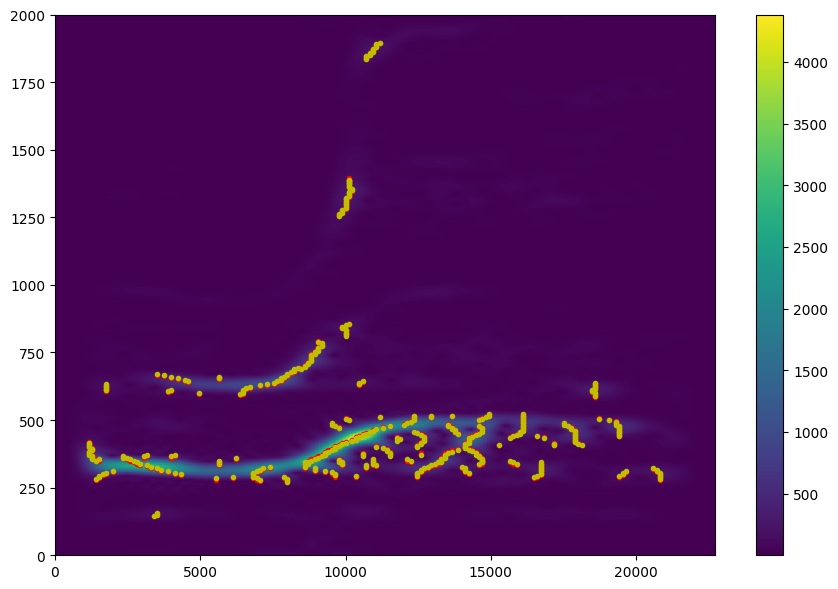

In [123]:
fig1, ax1 = plt.subplots(figsize=(9., 6.))
ax1.set(ylim=(0, 2000))

im1 = ax1.imshow(abs(Sx), origin='lower', aspect='auto',
                 extent=extents, cmap='viridis')
ax1.plot(peaks_t * x_scale, peaks_f * y_scale, 'r.')
ax1.plot(peaks_t * x_scale, IF, 'y.')

fig1.colorbar(im1)
fig1.tight_layout()

plt.show()

In [124]:
peaks_per_f = np.zeros(Sx.shape[1], dtype=int)
max_peak = np.zeros(peaks_per_f.size, dtype=int)

for i in range(peaks_t.size):
  peaks_per_f[peaks_t[i]] += 1
  if IF[i] > max_peak[peaks_t[i]]:
    max_peak[peaks_t[i]] = i

In [109]:
def Bin(fi):
  return np.floor(120*np.log2(fi/55) + 1)

def Threshold(a, t, g):
  if np.log10(Ai[max_peak[t]] / a) < g:
    return 1
  else: return 0

def Weight(a, b, h, fi):
  d = abs(Bin(fi/h) - b)/10
  if d <= 1:
    return (a**(h-1)) * np.cos(np.pi*d/2)**2
  else: return 0

In [125]:
alpha = 0.8
beta = 1
gamma = 2
Nh = 20

peaks_by_t = np.zeros((peaks_t.size, 2), dtype=int)
for i in range(peaks_t.size):
  peaks_by_t[i] = [peaks_t[i], i]
peaks_by_t = peaks_by_t[np.argsort(peaks_by_t[:,0])]

In [126]:
Sb = np.zeros((600, Sx.shape[1]))

index = 0
for l in range(Sb.shape[1]):
  for b in range(Sb.shape[0]):
    for n in range(peaks_per_f[l]):
      i = index + n
      ea = Threshold(Ai[peaks_by_t[i,1]], l, gamma)
      if ea == 0: continue
      ab = Ai[i]**beta
      for h in range(Nh):
        w = Weight(alpha, b, h+1, IF[peaks_by_t[i,1]])
        Sb[b, l] += ea * w * ab
  index += peaks_per_f[l]

Sb

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

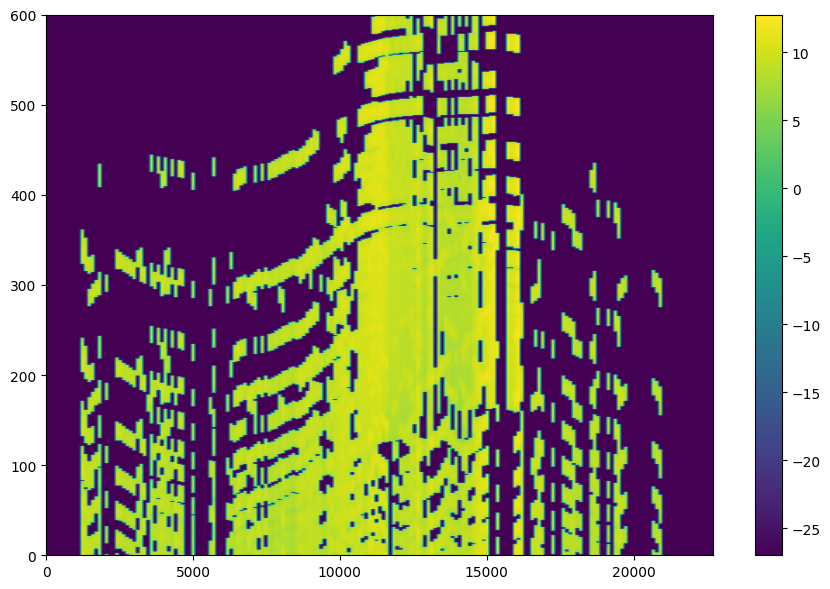

In [127]:
fig1, ax1 = plt.subplots(figsize=(9., 6.))

Sb2 = np.zeros(Sb.shape)
for i in range(Sb2.shape[0]):
  for j in range(Sb2.shape[1]):
    if Sb[i,j] != 0: Sb2[i,j] = np.log10(Sb[i,j])
    else: Sb2[i,j] = -27

new_extents = (extents[0], extents[1], extents[2], 600.0)
im1 = ax1.imshow(Sb2, origin='lower', aspect='auto',
                 extent=new_extents, cmap='viridis')

fig1.colorbar(im1)
fig1.tight_layout()

plt.show()

In [128]:
Speaks = sig.argrelmax(Sb, axis=1, order=5)

Speak_ids = np.zeros(0, dtype=int)
for i in range(Speaks[0].size):
  if abs(Sb[Speaks[0][i], Speaks[1][i]]) > 1e5:
    Speak_ids = np.append(Speak_ids, i)

Speaks_f = Speaks[0][Speak_ids]
Speaks_t = Speaks[1][Speak_ids]

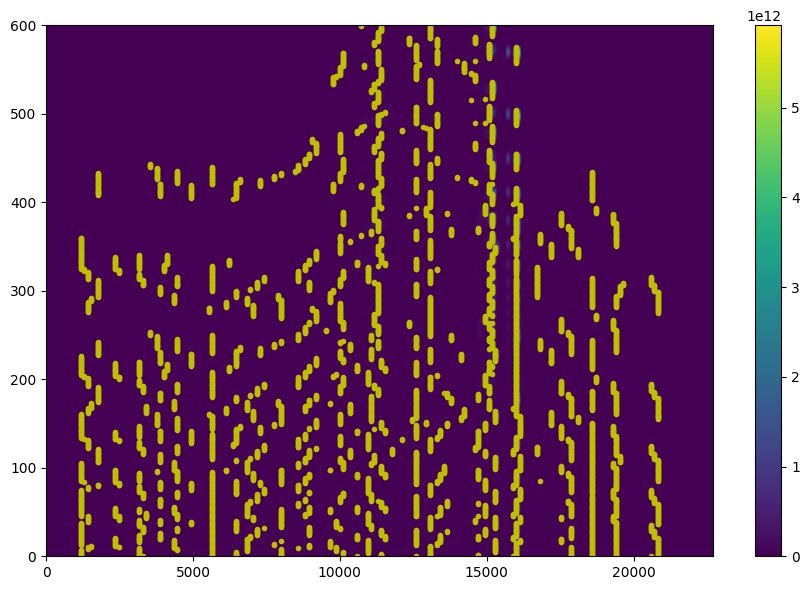

In [129]:
fig1, ax1 = plt.subplots(figsize=(9., 6.))

im1 = ax1.imshow(Sb, origin='lower', aspect='auto',
                 extent=new_extents, cmap='viridis')
ax1.plot(Speaks_t * x_scale, Speaks_f, 'y.')

fig1.colorbar(im1)
fig1.tight_layout()

plt.show()

In [ ]:
#with open("/content/sample_data/Sb.txt", "w") as txt:
#  for line in Sb:
#    for num in line:
#      txt.write(str(num) + ",")
#    txt.write("\n")

In [90]:
#wav.write("/content/sample_data/newsong.wav", sr, eq_data)